# Step 1 : Import Requiered Libraries and Load Data

In [5]:
import sys
from pathlib import Path

# Add project root to Python path
project_root = Path.cwd().parent  # Adjust if notebook is deeper
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from src.optimization import *  # Using our custom optimization functions
from src.data_processing import load_merged_data

# Set modern styling (replaces plt.style.use('seaborn'))
sns.set_theme(style="whitegrid")  # Other options: "darkgrid", "white", "ticks"
plt.style.use('ggplot')  # Alternative built-in styles: 'seaborn-v0_8', 'ggplot', 'bmh'

# Set color palette (husl is still valid)
sns.set_palette("husl")  # Other options: "Set2", "deep", "muted"
print(" ✅ Imported Succefully")

 ✅ Imported Succefully


In [6]:
# 1. Load and Prepare Data
# Load processed data
prices = load_merged_data()[['TSLA', 'SPY', 'BND']]  # Select our assets
print(f"Data from {prices.index[0].date()} to {prices.index[-1].date()}")

# Calculate daily returns
returns = prices.pct_change().dropna()
returns.head()


Data from 2025-08-07 to 2015-07-01


,TSLA,SPY,BND
datetime,,,
2025-08-06,-0.007323,0.000838,0.000408
2025-08-05,-0.034979,-0.007601,0.000815
2025-08-04,0.001749,0.005096,-0.000407
2025-08-01,-0.021438,-0.014972,-0.000679
2025-07-31,0.018637,0.016664,-0.005300


# Step 2 : Calculate Inputs for Optimization

In [7]:
# 2. Calculate Inputs for Optimization

# Annualized expected returns and covariance matrix
expected_returns = returns.mean() * 252  # 252 trading days
cov_matrix = returns.cov() * 252

print("Expected Annual Returns:")
print(expected_returns.to_frame().T)

print("\nCovariance Matrix:")
display(pd.DataFrame(cov_matrix, 
                    columns=expected_returns.index, 
                    index=expected_returns.index))


Expected Annual Returns:
       TSLA       SPY      BND
0 -0.112499 -0.093651  0.01095

Covariance Matrix:


,TSLA,SPY,BND
TSLA,0.349564,0.054090,0.002043
SPY,0.054090,0.033912,0.001141
BND,0.002043,0.001141,0.003091


# Step 3 : Portfolio Optimization

In [8]:
# 3. Portfolio Optimization


# Calculate optimal portfolios
min_vol_weights = minimize_volatility(expected_returns, cov_matrix)
max_sharpe_weights = maximize_sharpe(expected_returns, cov_matrix)

# Create weights DataFrame
weights_df = pd.DataFrame({
    'Min Volatility': min_vol_weights,
    'Max Sharpe': max_sharpe_weights
}, index=expected_returns.index)

print("Optimal Portfolio Weights:")
display(weights_df)

# Save weights
weights_df.to_csv('../outputs/portfolios/optimal_weights.csv')


Optimal Portfolio Weights:


,Min Volatility,Max Sharpe
TSLA,0.000000,0.0
SPY,0.056062,0.0
BND,0.943938,1.0


# Correlation Matrix Visualization

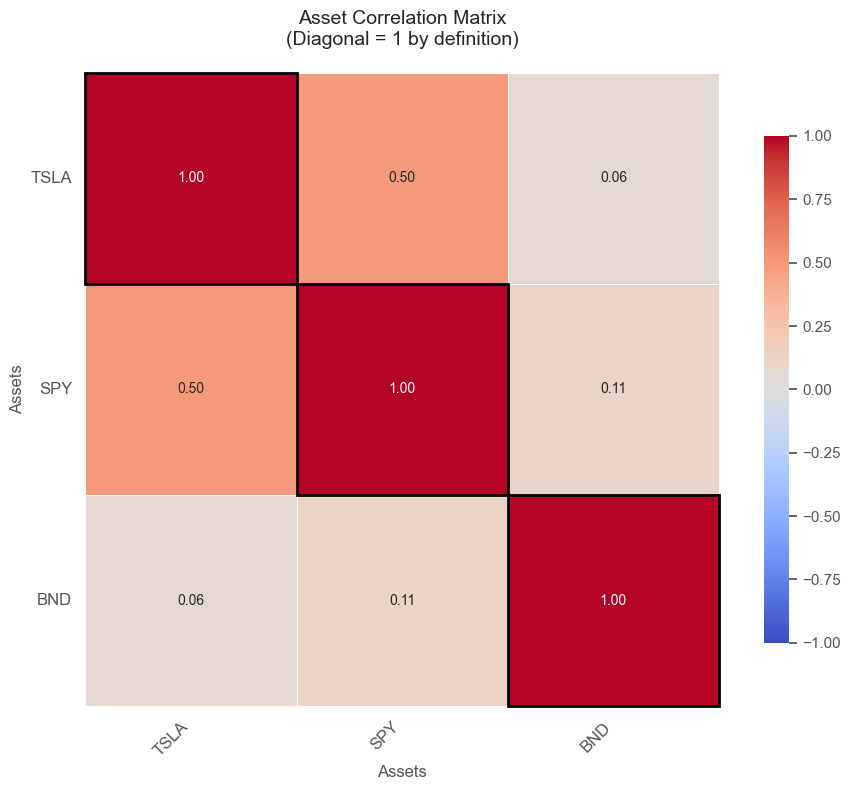

In [15]:
# Convert covariance matrix to correlation matrix
std_devs = np.sqrt(np.diag(cov_matrix))  # Get standard deviations
corr_matrix = cov_matrix / np.outer(std_devs, std_devs)  # Normalize

# Create the plot
plt.figure(figsize=(10, 8))
ax = sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,  # Fixed range for correlations
    vmax=1,
    center=0,
    square=True,
    linewidths=0.5,
    linecolor='white',
    cbar_kws={"shrink": 0.8},
    xticklabels=expected_returns.index,
    yticklabels=expected_returns.index
)

# Highlight diagonal in black
for i in range(len(corr_matrix)):
    ax.add_patch(plt.Rectangle(
        (i, i), 1, 1, 
        fill=False, 
        edgecolor='black', 
        lw=2, 
        clip_on=False
    ))

# Formatting
plt.title("Asset Correlation Matrix\n(Diagonal = 1 by definition)", 
          pad=20, fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.xlabel("Assets", fontsize=12)
plt.ylabel("Assets", fontsize=12)

plt.tight_layout()
plt.savefig(
    '../outputs/visualizations/correlation_matrix.png',
    dpi=300,
    bbox_inches='tight',
    transparent=False
)
plt.show()

# Step 4 : Efficient Frontier Analysis

C:\Users\dell\AppData\Local\Temp\ipykernel_18016\425184019.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  expected_returns[i],


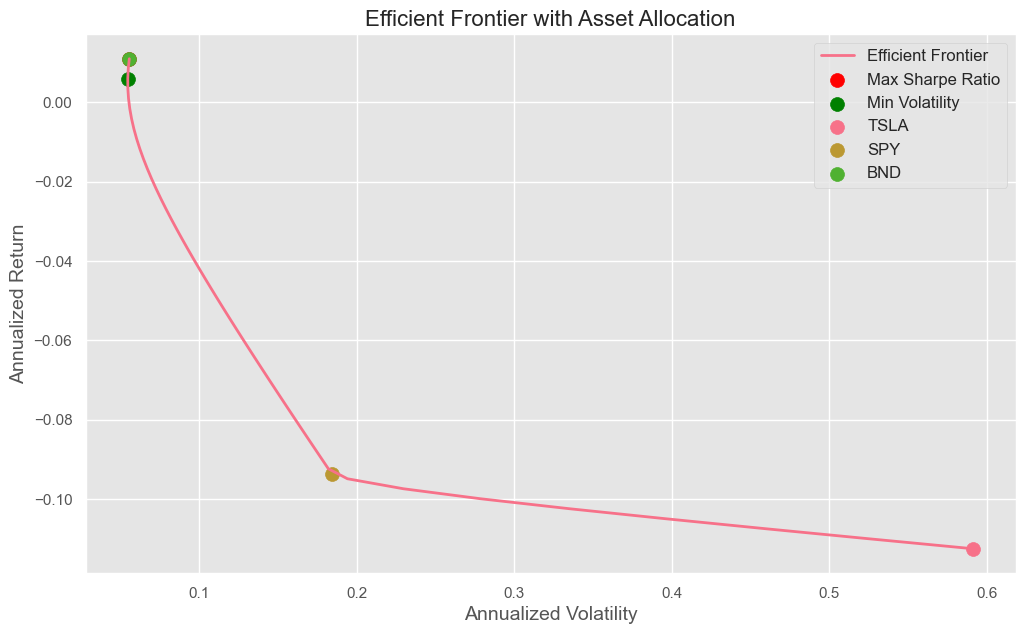

In [9]:
# 4. Efficient Frontier Analysis

# Generate efficient frontier
frontier = calculate_efficient_frontier(expected_returns, cov_matrix, points=50)

# Plot
plt.figure(figsize=(12, 7))
plt.plot(frontier['Volatility'], frontier['Return'], 
         label='Efficient Frontier', linewidth=2)

# Highlight key portfolios
max_sharpe_idx = frontier['Sharpe'].idxmax()
plt.scatter(frontier.loc[max_sharpe_idx, 'Volatility'],
            frontier.loc[max_sharpe_idx, 'Return'],
            c='red', s=100, label='Max Sharpe Ratio')

min_vol_idx = frontier['Volatility'].idxmin()
plt.scatter(frontier.loc[min_vol_idx, 'Volatility'],
            frontier.loc[min_vol_idx, 'Return'],
            c='green', s=100, label='Min Volatility')

# Individual assets
for i, asset in enumerate(expected_returns.index):
    plt.scatter(np.sqrt(cov_matrix.iloc[i,i]), 
                expected_returns[i], 
                s=100, label=asset)

plt.title('Efficient Frontier with Asset Allocation', fontsize=16)
plt.xlabel('Annualized Volatility', fontsize=14)
plt.ylabel('Annualized Return', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# Save plot
plt.savefig('../outputs/visualizations/efficient_frontier.png', 
            bbox_inches='tight', dpi=300)
plt.show()

# Step 5 : Portfolio Performance Metrics

In [10]:
# 5. Portfolio Performance Metrics

def calculate_metrics(weights, expected_returns, cov_matrix, risk_free_rate=0.02):
    """Calculate key portfolio metrics"""
    ret, vol = portfolio_performance(weights, expected_returns, cov_matrix)
    sharpe = (ret - risk_free_rate) / vol
    return {
        'Return': ret,
        'Volatility': vol,
        'Sharpe Ratio': sharpe,
        'Weights': dict(zip(expected_returns.index, weights))
    }

# Calculate for both portfolios
metrics = {
    'Min Volatility': calculate_metrics(min_vol_weights, expected_returns, cov_matrix),
    'Max Sharpe': calculate_metrics(max_sharpe_weights, expected_returns, cov_matrix)
}

# Display results
metrics_df = pd.DataFrame(metrics).T
print("Portfolio Performance Metrics:")
display(metrics_df)

# Save metrics
metrics_df.to_csv('../outputs/portfolios/performance_metrics.csv')


Portfolio Performance Metrics:


,Return,Volatility,Sharpe Ratio,Weights
Min Volatility,0.005086,0.054601,-0.273149,"{'TSLA': 0.0, 'SPY': 0.056061642138649045, 'BN..."
Max Sharpe,0.01095,0.055595,-0.162788,"{'TSLA': 0.0, 'SPY': 0.0, 'BND': 1.0}"


# Step 6 :  Weight Visualization

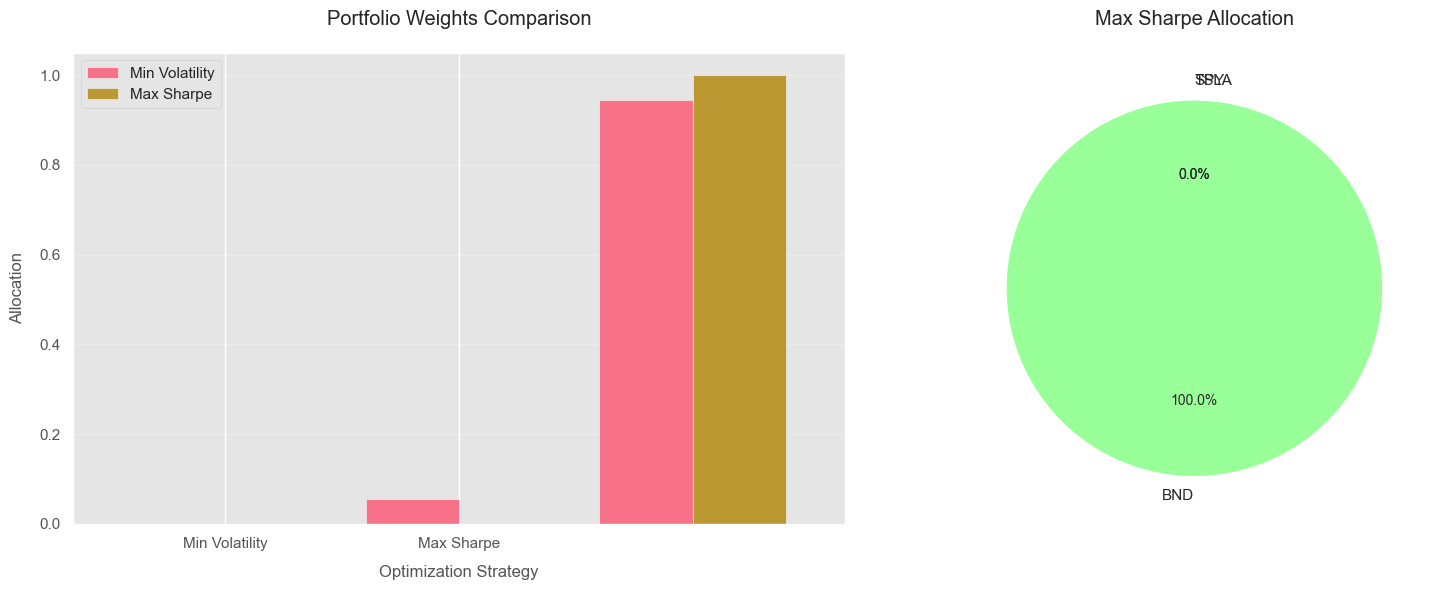

In [12]:
# Plot portfolio allocations
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# 1. Bar Plot (Fixed)
weights_df.plot(kind='bar', ax=ax[0], width=0.8)
ax[0].set_title('Portfolio Weights Comparison', pad=20)
ax[0].set_ylabel('Allocation', labelpad=10)
ax[0].set_xlabel('Optimization Strategy', labelpad=10)
ax[0].set_xticks(range(len(weights_df.columns)))  # Explicitly set ticks
ax[0].set_xticklabels(weights_df.columns, rotation=0)  # Use actual column names
ax[0].grid(axis='y', alpha=0.3)

# 2. Pie Chart (Max Sharpe only)
max_sharpe = weights_df['Max Sharpe']
ax[1].pie(max_sharpe, 
         labels=max_sharpe.index,
         autopct='%1.1f%%',
         colors=['#ff9999','#66b3ff','#99ff99'],
         startangle=90,
         wedgeprops={'linewidth': 1, 'edgecolor': 'white'})
ax[1].set_title('Max Sharpe Allocation', pad=20)

plt.tight_layout()
plt.savefig('../outputs/visualizations/portfolio_allocations.png', dpi=300, bbox_inches='tight')
plt.show()